In [19]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import math
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from collections import defaultdict

In [132]:
original = cv2.imread('white_lane.jpg',1)
original = cv2.resize(original, (600,400))
final1 = original #image to print final results on (for DBSCAN)
final2 = original  #image to print final results on (for K-Means)
canny = cv2.imread('canny.jpg',0)

In [91]:
def hough_transform(original, gray_img, threshold):
    """
    A function fitting lines that intersect >=threshold white pixels
    Input:
    - original - image we want to draw lines on
    - gray_img - image with white/black pixels, e.g. a result of Canny Edge Detection
    - threshold - if a line intersects more than threshold white pixels, draw it
    Return:
    - image_lines - result of applying the function
    - lines - rho and theta
    """
    lines = cv2.HoughLines(gray_img, 0.5, np.pi / 360, threshold)
    image_lines = original
    lines_ok = [] #list of parameters of lines that we want to take into account (not horizontal)
            
    if lines is not None:
        for i in range(0, len(lines)):
            rho = lines[i][0][0]
            theta = lines[i][0][1]
            #discard horizontal lines
            m = -math.cos(theta)/(math.sin(theta)+1e-10) #adding some small value to avoid dividing by 0
            if abs(m) < 0.3:
                continue
            else:
                a = math.cos(theta)
                b = math.sin(theta)
                x0 = a * rho
                y0 = b * rho
                pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
                pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
                cv2.line(image_lines, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)
                lines_ok.append([rho,theta])
        
    lines_ok = np.array(lines_ok)
                    
    return image_lines, lines_ok

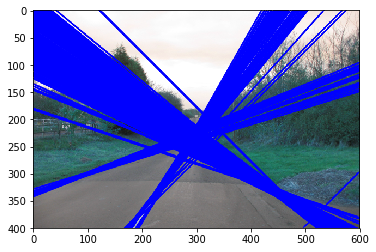

In [127]:
#the threshold in on purpose not tuned well in order to test clustering algorithms' performance
image_lines, lines = hough_transform(original, canny, 38) 
lines = lines.reshape(lines.shape[0],2)
#displaying the outcome of hough transform algorithm
plt.imshow(image_lines)
plt.show()

## K-Means Clustering Algorithm

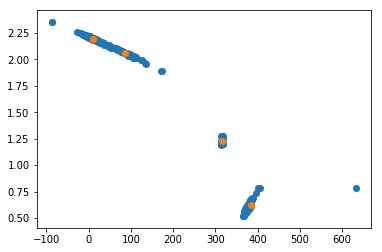

[[  10.48914337    2.19443536]
 [ 384.61364746    0.62316185]
 [ 315.80880737    1.22532368]
 [  86.08802032    2.05887389]]


In [129]:
#preprocessing features to be in (0-1) range
scaler = MinMaxScaler()
scaler.fit(lines)
lines = scaler.fit_transform(lines)

#checking K-Means Clustering Algorithm performance
n_clusters=4
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(lines)
centroids = kmeans.cluster_centers_

lines = scaler.inverse_transform(lines) #getting back our original values
centroids = scaler.inverse_transform(centroids) #scaling centroids to be simmilar to our original lines

plt.scatter(lines[:,0],lines[:,1])
plt.scatter(centroids[:,0],centroids[:,1])
plt.show() 

print(centroids)

### Result of applying K-Means Clustering Algorithm

In [130]:
#printing the result on original image
for rho, theta in centroids:
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(final2, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)

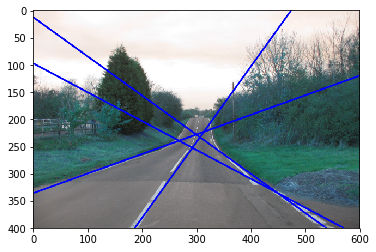

In [131]:
plt.imshow(final2)

## DBSCAN Clustering Algorithm

3 clusters detected


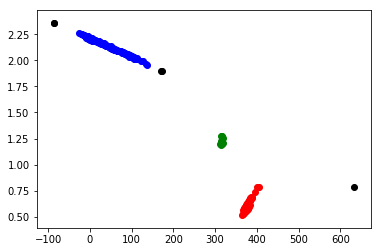

In [133]:
#preprocessing features to be in (0-1) range
scaler = MinMaxScaler()
scaler.fit(lines)
lines = scaler.fit_transform(lines)

db = DBSCAN(eps=0.05, min_samples=5).fit(lines) #applying DBSCAN Algorithm on our normalized lines
labels = db.labels_

lines = scaler.inverse_transform(lines) #getting back our original values

num_clusters = np.max(labels) + 1
print(num_clusters, "clusters detected")

for i, line in enumerate(lines):
    if labels[i] == 0:
        color = 'g'
    elif labels[i] == 1:
        color = 'b'
    elif labels[i] == 2:
        color = 'r'
    elif labels[i] == 3:
        color = 'y'
    elif labels[i] == 4:
        color = 'm'
    elif labels[i] == 5:
        color = 'c'
    elif labels[i] == -1:
        color = 'k'
    
    
    plt.scatter(line[0],line[1],c=color)
    
plt.show()

grouped = defaultdict(list)
#grouping lines by clusters
for i, label in enumerate(labels):
    grouped[label].append([lines[i,0],lines[i,1]])

means = []
#getting mean values by cluster
for i in range(num_clusters):
    mean = np.mean(np.array(grouped[i]), axis=0)
    means.append(mean)
means = np.array(means)

#black dots are classified as noise

### Result of applying DBSCAN Clustering Algorithm

In [134]:
#printing the result on original image
for rho, theta in means:
    a = math.cos(theta)
    b = math.sin(theta)
    x0 = a * rho
    y0 = b * rho
    pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
    pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
    cv2.line(final1, pt1, pt2, (0,0,255), 2, cv2.LINE_AA)

[[ 315.80880737    1.2253238 ]
 [  49.00735474    2.1257093 ]
 [ 378.83139038    0.61938894]]


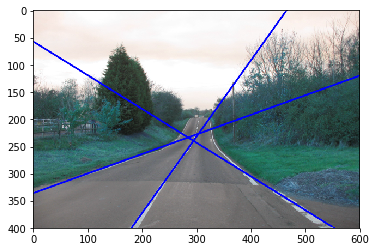

In [135]:
print(means)
plt.imshow(final1)

# Conclusions

I think that DBSCAN is a more preferable algorithm in this case, since we don't have to explicitly declare the number of clusters (we can have 3 lines and sometimes 1 line, K-Means fails on this). Also on this example DBSCAN did better. It also reduces noise by not taking into account lines that don't occur in bigger clusters. The downside of DBSCAN is that it is sensitive to its parameters, that we'll have to tune carefully during testing